# Enrichment Analysis Notebook

Compares the results of SPINDOCTOR gene set summarization vs statistical ontological enrichment.

Draft: https://docs.google.com/document/d/1H103ux6Dd1_bPM0un4RwutBLcYJx-0ybil2AwlAvG_Q/edit#

## Initial setup

Here we take care of imports, defining the data dictionary for the pandas dataframes

In [30]:
# parameters
# experiment_results = "results/human-combined.yaml"
results_dir = "results/human/gpt4"

In [2]:
!pip --version

pip 23.2.1 from /Users/marcin/.pyenv/versions/3.9.8/lib/python3.9/site-packages/pip (python 3.9)


In [31]:
!pip list

Package                    Version
-------------------------- -----------
adeft                      0.11.2
aiohttp                    3.8.5
aiosignal                  1.3.1
airium                     0.2.5
altair                     5.1.1
aniso8601                  9.0.1
annotated-types            0.5.0
antlr4-python3-runtime     4.9.3
anyio                      4.0.0
appdirs                    1.4.4
appnope                    0.1.3
argon2-cffi                23.1.0
argon2-cffi-bindings       21.2.0
arrow                      1.2.3
asttokens                  2.2.1
async-lru                  2.0.4
async-timeout              4.0.3
attrs                      23.1.0
Babel                      2.12.1
backcall                   0.2.0
bcp47                      0.0.4
beautifulsoup4             4.12.2
bioc                       2.1
bleach                     6.0.0
blinker                    1.6.2
boto3                      1.28.40
botocore                   1.31.40
cachetools                 

In [35]:
import yaml
from yaml import Loader
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import colorsys
import seaborn as sns
from oaklib import get_adapter
from oaklib.datamodels.vocabulary import IS_A, PART_OF
from ontogpt.evaluation.enrichment.eval_enrichment import EvalEnrichment
go = get_adapter("sqlite:obo:go")
hgnc = get_adapter("sqlite:obo:hgnc")

In [36]:
# ruamel is faster
from ruamel.yaml import YAML
ryaml = YAML()

In [37]:
#from ontogpt.utils.gene_set_utils import populate_ids_and_symbols, GeneSet
#ee = EvalEnrichment()
#ee.ontology = go
#ee.load_annotations("../tests/input/genes2go.tsv.gz")

In [38]:
TURBO = "gpt-3.5-turbo"
DAVINCI = "text-davinci-003"
GPT4 = "gpt-4"
MODELS = [TURBO, DAVINCI, GPT4]

In [39]:
# data dictionary
MODEL = "model"
METHOD = "method"
HAS_TOP_HIT = "has top term"
IN_TOP_5 = "in top 5"
IN_TOP_10 = "in top 10"
RANK = "rank"
SIZE_OVERLAP = "size overlap"
SIMILARITY = "similarity"
NR_SIZE_OVERLAP = "nr size overlap"
NR_SIMILARITY = "nr similarity"
GENESET = "geneset"
PROMPT_VARIANT = "prompt_variant"
SOURCE_GENESET = "source geneset"
GENESET_DESCRIPTION = "description"
GENESET_SIZE = "geneset_size"
TRUNCATION_FACTOR = "truncation factor"
NUM_TERMS = "num terms"
NUM_GO_TERMS = "num GO terms"
UNPARSED = "unparsed"
NUM_UNPARSED = "num unparsed"
TERM_IDS = "term ids"
GO_TERM_IDS = "go term ids"
GO_TERM_P_VALUES = "go term p values"
MAX_P_VALUE = "max p value"
MIN_P_VALUE = "min p value"
MEAN_P_VALUE = "mean p value"
PROPOTION_SIGNIFICANT = "proportion significant"
NOVEL = "unannotated"
NOVEL_LABELS = "unannotated labels"
NUM_NOVEL = "num unannotated"
GENE_RANDOMIZATION_FACTOR = "gene_randomization_factor"
SUMMARY = "summary"




In [40]:
from ontogpt.evaluation.enrichment.eval_enrichment import GeneSetComparison

In [41]:
# assumes comparisons have been run and concatenated (see Makefile) 
import glob
def load_comparisons():
    comps = []
    for fn in glob.glob(f"{results_dir}/*.yaml"):
        print(fn)
        with open(fn) as f:
            #obj = yaml.load(f, Loader)
            #obj = yaml.safe_load(f)
            obj = ryaml.load(f)
            comps.extend([GeneSetComparison(**x) for x in obj])
    return comps

In [42]:
comps = load_comparisons()

results/human/gpt4/canonical-glycolysis-gocam-results-2.yaml
results/human/gpt4/bicluster_RNAseqDB_1001-results-2.yaml
results/human/gpt4/HALLMARK_HYPOXIA-results-2.yaml
results/human/gpt4/HALLMARK_DNA_REPAIR-results-2.yaml
results/human/gpt4/HALLMARK_G2M_CHECKPOINT-results-2.yaml
results/human/gpt4/EDS-results-2.yaml
results/human/gpt4/HALLMARK_IL2_STAT5_SIGNALING-results-2.yaml
results/human/gpt4/HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION-results-2.yaml
results/human/gpt4/HALLMARK_PI3K_AKT_MTOR_SIGNALING-results-2.yaml
results/human/gpt4/HALLMARK_COAGULATION-results-2.yaml
results/human/gpt4/peroxisome-results-2.yaml
results/human/gpt4/HALLMARK_APICAL_JUNCTION-results-2.yaml
results/human/gpt4/HALLMARK_ANGIOGENESIS-results-2.yaml
results/human/gpt4/go-postsynapse-calcium-results-2.yaml
results/human/gpt4/HALLMARK_BILE_ACID_METABOLISM-results-2.yaml
results/human/gpt4/HALLMARK_CHOLESTEROL_HOMEOSTASIS-results-2.yaml
results/human/gpt4/bicluster_RNAseqDB_1002-results-2.yaml
results/huma

In [43]:
len(comps)

144

In [44]:

def filter_redundant(term_ids):
    """
    find leaf nodes in a set of term ids
    """
    cumulative_ancs = set()
    visited = set()
    for t in term_ids:
        visited.add(t)
        if t in cumulative_ancs:
            # a descendant of t has been encountered
            continue
        ancs = list(go.ancestors(t, [IS_A, PART_OF]))
        cumulative_ancs.update(ancs)
        if (visited-{t}).intersection(ancs):
            # t is a descendant of a term that has been encountered
            continue
        yield t

# test
list(filter_redundant(["GO:0005773", "GO:0005634", "GO:0031965", "GO:0008150"]))

['GO:0005773', 'GO:0005634', 'GO:0008150']

In [45]:
import statistics
import re
def eval_payload(comp, payload, expected, closure):
    """
    Create a dataframe row from a payload in a comparison
    """
    expected_nr_ids = list(filter_redundant(expected.term_ids))
    name = comp.name
    model = payload.model
    method = payload.method
    if not model:
        model = "N/A"
    tf = payload.truncation_factor
    if not tf:
        tf = 1.0
    unparsed_term_ids = [t for t in payload.term_ids if not re.match(r'^\S+:w+$', t)]
    go_term_ids = [t for t in payload.term_ids if t.startswith("GO:")]
    nr_term_ids = list(filter_redundant(go_term_ids))
    obj = {MODEL: model, METHOD: method, GENESET: name, TRUNCATION_FACTOR: tf, PROMPT_VARIANT: payload.prompt_variant}
    obj[SUMMARY] = payload.summary
    name_toks = name.split("-")
    obj[SOURCE_GENESET] = "-".join(name_toks[0:-1])
    # obj[GENESET_DESCRIPTION] = comp.
    obj[GENE_RANDOMIZATION_FACTOR] = int(name_toks[-1])
    if not expected.term_ids:
        #print(f"Nothing expected for {name}")
        # top_term_id = "FAKE:123"
        return
    else:
        top_term_id = expected.term_ids[0]
    obj[HAS_TOP_HIT] = top_term_id in payload.term_ids
    in_top_5 = False
    in_top_10 = False
    if top_term_id in payload.term_ids:
        rank = payload.term_ids.index(top_term_id)
        obj[RANK] = rank
        in_top_5 = rank < 5
        in_top_10 = rank < 10
    obj[IN_TOP_5] = in_top_5
    obj[IN_TOP_10] = in_top_10
    overlap = set(go_term_ids).intersection(expected.term_ids)
    obj[SIZE_OVERLAP] = len(overlap)
    nr_overlap = set(nr_term_ids).intersection(expected_nr_ids)
    obj[NR_SIZE_OVERLAP] = len(nr_overlap)
    size_union = len(set(go_term_ids).union(expected.term_ids))
    if size_union:
        obj[SIMILARITY] = len(overlap) / len(set(go_term_ids).union(expected.term_ids))
    nr_size_union = len(set(nr_term_ids).union(expected_nr_ids))
    if nr_size_union:
        obj[NR_SIMILARITY] = len(nr_overlap) / len(set(nr_term_ids).union(expected_nr_ids))
    obj['number_of_terms'] = len(payload.term_ids)
    obj[NUM_GO_TERMS] = len(go_term_ids)
    obj[GENESET_SIZE] = len(comp.gene_symbols)
    obj[TERM_IDS] = payload.term_ids
    obj['term_strings'] = payload.term_strings
    obj[GO_TERM_IDS] = go_term_ids
    obj[NUM_TERMS] = len(payload.term_ids)
    obj[NUM_UNPARSED] = len(unparsed_term_ids)
    obj[UNPARSED] = unparsed_term_ids
    p_vals = []
    for t in go_term_ids:
        p_val = 1.0
        for e in expected.enrichment_results:
            if e.class_id == t:
                p_val = e.p_value_adjusted
                break
        p_vals.append(p_val)
    obj[GO_TERM_P_VALUES] = p_vals
    if p_vals:
        obj[MAX_P_VALUE] = max(p_vals)
        obj[MIN_P_VALUE] = min(p_vals)
        obj[MEAN_P_VALUE] = statistics.mean(p_vals)
        obj[PROPOTION_SIGNIFICANT] = len([v for v in p_vals if v<=0.05]) / len(p_vals)
    novel = []
    novel_labels = []
    # enriched_terms = [e.class_id for e in expected.enrichment_results]
    for t in go_term_ids:
        if t not in closure:
            novel.append(t)
            novel_labels.append(go.label(t))
    obj[NOVEL] = novel
    obj[NOVEL_LABELS] = novel_labels
    obj[NUM_NOVEL] = len(novel)
    return obj

objs = []
for comp in comps:
    expected = comp.payloads["standard"]
    closure = comp.payloads["closure"].term_ids
    #gene_set = GeneSet(name=comp.name, gene_symbols=comp.gene_symbols)
    #populate_ids_and_symbols(gene_set, hgnc)
    
    for method, payload in comp.payloads.items():
        obj = eval_payload(comp, payload, expected, closure)
        if obj:
            objs.append(obj)
            # temp
            if not obj[METHOD]:
                obj[METHOD] = method
df = pd.DataFrame(objs)
df.to_csv("enr.csv")
df

,model,method,geneset,truncation factor,prompt_variant,summary,source geneset,gene_randomization_factor,has top term,rank,...,num unparsed,unparsed,go term p values,max p value,min p value,mean p value,proportion significant,unannotated,unannotated labels,num unannotated
0,gpt-4,no_synopsis,glycolysis-gocam-0,1.0,v1,Summary: Glycolysis-related processes are over...,glycolysis-gocam,0,True,0.0,...,4,"[GO:0006096, GO:0006006, energy production, at...","[1.0119188162063915e-24, 6.945787784989671e-17]",6.95e-17,1.01e-24,3.47e-17,1.00,[],[],0
1,gpt-4,no_synopsis,glycolysis-gocam-0,1.0,v2,Summary: Glycolytic pathway and energy metabol...,glycolysis-gocam,0,True,0.0,...,4,"[GO:0006096, GO:0006006, energy production, at...","[1.0119188162063915e-24, 6.945787784989671e-17]",6.95e-17,1.01e-24,3.47e-17,1.00,[],[],0
2,gpt-4,ontological_synopsis,glycolysis-gocam-0,1.0,v1,Summary: Glycolytic process and carbohydrate m...,glycolysis-gocam,0,True,0.0,...,6,"[GO:0006096, GO:0005975, GO:0046835, fructose ...","[1.0119188162063915e-24, 2.8866750813820344e-1...",1.00e+00,1.01e-24,5.00e-01,0.50,[],[],0
3,gpt-4,ontological_synopsis,glycolysis-gocam-0,1.0,v2,Summary: Glycolytic pathway and carbohydrate m...,glycolysis-gocam,0,True,0.0,...,9,"[GO:0006096, GO:0005975, glucose-6-phosphate m...","[1.0119188162063915e-24, 2.8866750813820344e-1...",1.00e+00,1.01e-24,5.02e-01,0.50,[],[],0
4,gpt-4,narrative_synopsis,glycolysis-gocam-0,1.0,v1,Summary: The genes are involved in glycolysis ...,glycolysis-gocam,0,True,0.0,...,4,"[GO:0006096, GO:0006006, energy production, at...","[1.0119188162063915e-24, 6.945787784989671e-17]",6.95e-17,1.01e-24,3.47e-17,1.00,[],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261,N/A,standard,HALLMARK_MTORC1_SIGNALING-1,1.0,None,None,HALLMARK_MTORC1_SIGNALING,1,True,0.0,...,214,"[GO:0044283, GO:0044281, GO:0005737, GO:001975...","[3.1920405442233086e-26, 1.6638228530612904e-2...",4.97e-02,3.19e-26,5.65e-03,1.00,[],[],0
3262,N/A,standard_no_ontology,HALLMARK_MTORC1_SIGNALING-1,1.0,None,None,HALLMARK_MTORC1_SIGNALING,1,False,NaN,...,40,"[GO:0005829, GO:0070062, GO:0006695, GO:000609...","[7.276181355709892e-13, 6.312656560780503e-13,...",1.00e+00,2.88e-18,2.30e-01,0.78,[],[],0
3263,N/A,random,HALLMARK_MTORC1_SIGNALING-1,1.0,None,None,HALLMARK_MTORC1_SIGNALING,1,False,NaN,...,162,"[GO:0006919, GO:0007416, GO:0015909, GO:003107...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.00e+00,2.88e-18,9.38e-01,0.06,"[GO:0007416, GO:0035866, GO:0008272, GO:003052...","[synapse assembly, alphav-beta3 integrin-PKCal...",62
3264,N/A,rank_based,HALLMARK_MTORC1_SIGNALING-1,1.0,None,None,HALLMARK_MTORC1_SIGNALING,1,False,NaN,...,180,"[GO:0031901, GO:0008150, GO:0019899, GO:000587...","[1.0, 0.019904234975556816, 1.0, 1.0, 1.0, 1.0...",1.00e+00,2.88e-18,9.06e-01,0.09,"[GO:0070374, GO:0005096, GO:0005085, GO:000591...","[positive regulation of ERK1 and ERK2 cascade,...",7


In [46]:
df.to_csv(f"{results_dir}/combined.csv", index=False)
#df_orig = df
#df = pd.read_csv(f"{results_dir}/combined.csv")

In [47]:
#df = df_orig

The above data frame has one row per run of a method

In [48]:
df[[MODEL, METHOD]].drop_duplicates()

,model,method
0,gpt-4,no_synopsis
2,gpt-4,ontological_synopsis
4,gpt-4,narrative_synopsis
6,gpt-3.5-turbo,no_synopsis
8,gpt-3.5-turbo,ontological_synopsis
...,...,...
18,N/A,standard
19,N/A,standard_no_ontology
20,N/A,random
21,N/A,rank_based


In [49]:
df[[SOURCE_GENESET]].drop_duplicates()

,source geneset
0,glycolysis-gocam
46,HALLMARK_HYPOXIA
92,HALLMARK_DNA_REPAIR
138,HALLMARK_G2M_CHECKPOINT
184,EDS
...,...
3036,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY
3082,HALLMARK_HEDGEHOG_SIGNALING
3128,T cell proliferation
3174,mtorc1


## TABLE: All gene sets and their sizes

Copy this to [gene set](https://docs.google.com/spreadsheets/d/1gGO5IHEg-N0hivtHBO6-rdXtin8hPhw-zv6eYOBgXcE/edit#gid=1762479413) tab

In [50]:
df[[SOURCE_GENESET, GENESET_SIZE]].drop_duplicates().style.hide()

source geneset,geneset_size
glycolysis-gocam,10
glycolysis-gocam,9
HALLMARK_HYPOXIA,200
HALLMARK_HYPOXIA,180
HALLMARK_DNA_REPAIR,150
HALLMARK_DNA_REPAIR,135
HALLMARK_G2M_CHECKPOINT,200
HALLMARK_G2M_CHECKPOINT,180
EDS,19
EDS,18


In [51]:
df[[MODEL, METHOD]].drop_duplicates().style.hide()

model,method
gpt-4,no_synopsis
gpt-4,ontological_synopsis
gpt-4,narrative_synopsis
gpt-3.5-turbo,no_synopsis
gpt-3.5-turbo,ontological_synopsis
gpt-3.5-turbo,narrative_synopsis
text-davinci-003,no_synopsis
text-davinci-003,ontological_synopsis
text-davinci-003,narrative_synopsis
N/A,standard


In [52]:
df[[MODEL, METHOD, PROMPT_VARIANT]].drop_duplicates().style.hide()

model,method,prompt_variant
gpt-4,no_synopsis,v1
gpt-4,no_synopsis,v2
gpt-4,ontological_synopsis,v1
gpt-4,ontological_synopsis,v2
gpt-4,narrative_synopsis,v1
gpt-4,narrative_synopsis,v2
gpt-3.5-turbo,no_synopsis,v1
gpt-3.5-turbo,no_synopsis,v2
gpt-3.5-turbo,ontological_synopsis,v1
gpt-3.5-turbo,ontological_synopsis,v2


## Subset Analysis

In [53]:

go = get_adapter("sqlite:obo:go")
subsets = list(go.subsets())
subsets_by_term = defaultdict(list)
for subset in subsets:
    members = [m for m in go.subset_members(subset) if m.startswith("GO:")]
    for t in members:
        subsets_by_term[t].append(subset)
    members_ancs = go.ancestors(members)
    anc_subset = f"anc_of_{subset}"
    for a in members_ancs:
        if a not in members:
            subsets_by_term[a].append(anc_subset)

In [54]:
go = get_adapter("sqlite:obo:go")
labels = list(go.labels(go.entities()))

In [55]:
lmap = {id: label for id, label in labels}

In [56]:
objs = []
n = 0
for row in df.to_dict(orient="records"):
    n += 1
    if n % 500 == 0:
        print(row[GENESET])
    for t in row[GO_TERM_IDS]:
        obj = {MODEL: row.get(MODEL), METHOD: row.get(METHOD) , "term": t, "label": lmap.get(t, t)}
        for s in subsets_by_term.get(t, []):
            obj[s] = 1
        objs.append(obj)
print(len(objs))
subsets_df=pd.DataFrame(objs) 
pd.set_option('display.max_rows', 10)
subsets_df

HALLMARK_APICAL_JUNCTION-1
HALLMARK_KRAS_SIGNALING_UP-1
tf-downreg-colorectal-1
HALLMARK_MYC_TARGETS_V1-0
HALLMARK_WNT_BETA_CATENIN_SIGNALING-0
HALLMARK_APICAL_SURFACE-0
759141


,model,method,term,label,anc_of_gocheck_do_not_annotate,goslim_plant,goslim_pir,goslim_chembl,goslim_agr,goslim_metagenomics,...,anc_of_gocheck_do_not_manually_annotate,goslim_mouse,anc_of_goslim_candida,anc_of_goslim_mouse,anc_of_goslim_plant,anc_of_goslim_flybase_ribbon,anc_of_goslim_agr,gocheck_do_not_annotate,gocheck_do_not_manually_annotate,goslim_synapse
0,gpt-4,no_synopsis,GO:0006096,glycolytic process,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,gpt-4,no_synopsis,GO:0006006,glucose metabolic process,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,gpt-4,no_synopsis,GO:0006096,glycolytic process,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,gpt-4,no_synopsis,GO:0006006,glucose metabolic process,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,gpt-4,ontological_synopsis,GO:0006096,glycolytic process,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759136,N/A,closure,GO:1903580,positive regulation of ATP metabolic process,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
759137,N/A,closure,GO:2001169,regulation of ATP biosynthetic process,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
759138,N/A,closure,GO:2001171,positive regulation of ATP biosynthetic process,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
759139,N/A,closure,GO:2001293,malonyl-CoA metabolic process,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### All subsets

In [57]:
subsets_df.fillna(0).groupby([MODEL, METHOD]).mean(numeric_only=True).style.highlight_max(axis=1, props='font-weight:bold').format(precision=3)

In [58]:
def agg_table(this_df, cols, exclude=[None]):
    qcols = [MODEL, METHOD] + cols
    agg_df = this_df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
    for x in exclude:
        agg_df= agg_df.query(f"method != '{x}'")
    return agg_df.reset_index().style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

pd.options.display.precision = 2
pd.set_option("display.precision", 2)

## TABLE: MAIN RESULTS

In [59]:
CORE_METRICS = [PROPOTION_SIGNIFICANT, HAS_TOP_HIT, NUM_GO_TERMS, NUM_NOVEL, NUM_UNPARSED]
EXCLUDE = ["standard", "standard no ontology", "random", "rank based", "closure"]
agg_table(df, CORE_METRICS, EXCLUDE)
#means.query("method != 'standard'").style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)
#

,model,method,proportion significant,has top term,num GO terms,num unannotated,num unparsed
0,gpt-3.5-turbo,narrative synopsis,0.652,0.148,3.835,0.155,5.729
1,gpt-3.5-turbo,no synopsis,0.657,0.201,4.905,0.194,6.965
2,gpt-3.5-turbo,ontological synopsis,0.623,0.155,3.574,0.102,5.803
3,gpt-4,narrative synopsis,0.600,0.113,4.303,0.137,8.011
4,gpt-4,no synopsis,0.653,0.141,4.581,0.109,7.479
5,gpt-4,ontological synopsis,0.608,0.165,5.616,0.137,7.873
6,text-davinci-003,narrative synopsis,0.371,0.092,4.282,0.335,12.158
7,text-davinci-003,no synopsis,0.409,0.077,3.303,0.264,10.243
8,text-davinci-003,ontological synopsis,0.315,0.099,6.923,0.338,13.782


method
['model', 'method', 'proportion significant', 'has top term', 'num GO terms', 'num unannotated', 'num unparsed']
(9, 5)
cols
Index(['proportion significant', 'has top term', 'num GO terms',
       'num unannotated', 'num unparsed'],
      dtype='object')
index
MultiIndex([(   'gpt-3.5-turbo',   'narrative synopsis'),
            (   'gpt-3.5-turbo',          'no synopsis'),
            (   'gpt-3.5-turbo', 'ontological synopsis'),
            (           'gpt-4',   'narrative synopsis'),
            (           'gpt-4',          'no synopsis'),
            (           'gpt-4', 'ontological synopsis'),
            ('text-davinci-003',   'narrative synopsis'),
            ('text-davinci-003',          'no synopsis'),
            ('text-davinci-003', 'ontological synopsis')],
           names=['model', 'method'])
model             method              
gpt-3.5-turbo     narrative synopsis      24.75
                  no synopsis             25.33
                  ontological synops

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_60847/1221940159.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(agg_df_plot.index[i], (xs[i], ys[i]))


<Figure size 600x600 with 0 Axes>

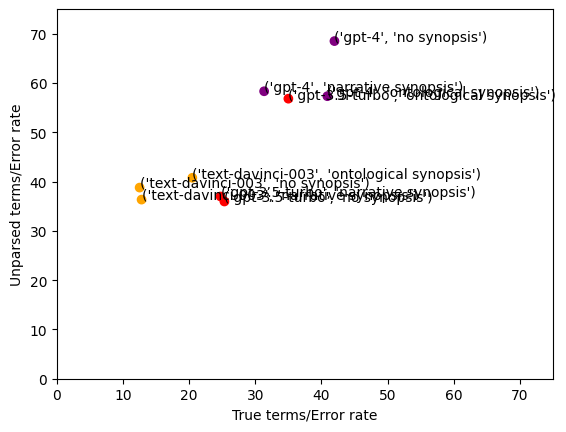

In [60]:

qcols = [MODEL, METHOD] + CORE_METRICS

print(METHOD)
#agg_df_orig = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
#agg_df_plot = pd.DataFrame( columns=agg_df_orig.columns)#NULL#pd.DataFrame() 
#print(EXCLUDE)
#agg_df_plot = agg_df_plot.query(f"method in @METHOD")


print(qcols)
agg_df_plot = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_plot= agg_df_plot.query(f"method != '{x}'")
    
print(agg_df_plot.shape)
print("cols")
print(agg_df_plot.columns)

print("index")
print(agg_df_plot.index)

newindex = agg_df_plot.index
#len = agg_df.index.to_flat_index().size()
#print(len)
#for i in range(1,len):
#    newindex[i] = agg_df.index[i]

#print(agg_df.loc[:, 'model'])

#print(agg_df['num GO terms'])

#rework for significant GO terms
xs = agg_df_plot['num GO terms']/agg_df_plot['num unannotated']
ys = agg_df_plot['num unparsed']/agg_df_plot['num unannotated']
#print(agg_df.index)

print(xs)
yells = ["yellow"]*5
reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3
#colors = [*yells, *reds, *purps, *orans]
colors = [*reds, *purps, *orans]
print(colors)

plt.figure(figsize=(6,6))
fig, ax = plt.subplots()

ax.scatter(xs,ys,
           c=colors)
#, label=agg_df.index

for i in range(0,len(xs)):
    ax.annotate(agg_df_plot.index[i], (xs[i], ys[i]))
    
ax.set_xlabel("True terms/Error rate")
ax.set_ylabel("Unparsed terms/Error rate")

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

plt.xlim(0,75)
plt.ylim(0,75)

plt.savefig("true_vs_unparsed_vs_error.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Core subsets

Copy this to [subsets tab](https://docs.google.com/spreadsheets/d/1gGO5IHEg-N0hivtHBO6-rdXtin8hPhw-zv6eYOBgXcE/edit#gid=669935942)

In [61]:
subsets_cols =  [MODEL, METHOD, "goslim_generic", "anc_of_goslim_generic", "goslim_agr", "anc_of_goslim_agr"]
subsets_grouped = subsets_df.fillna(0).groupby([MODEL, METHOD])[subsets_cols]
means = subsets_grouped.mean(numeric_only=True)
means["closure_of_goslim_generic"] = means["goslim_generic"] + means["anc_of_goslim_generic"]
means["closure_of_goslim_agr"] = means["goslim_agr"] + means["anc_of_goslim_agr"]
means.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

### TABLE: Above the shoreline in key subsets

[anc subsets tab](https://docs.google.com/spreadsheets/d/1gGO5IHEg-N0hivtHBO6-rdXtin8hPhw-zv6eYOBgXcE/edit#gid=345667144)

In [62]:
sorted_means = means.sort_values("anc_of_goslim_generic", ascending=False)
filtered = sorted_means[["anc_of_goslim_generic", "anc_of_goslim_agr"]]
filtered.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [63]:
means[["anc_of_goslim_generic", "anc_of_goslim_agr"]].sort_values("anc_of_goslim_agr", ascending=True).style.highlight_min(axis=0, props='font-weight:bold').format(precision=3)

In [64]:
# Reset the index of the pivoted DataFrame to have 'profession' as a column
#subsets_df = subsets_df.fillna(0).groupby([MODEL, METHOD])[subsets_cols].mean(numeric_only=True).reset_index()

# Melt the DataFrame to have 'category', 'profession', and 'percentage' columns
#melted_df = subsets_df.melt(id_vars=[MODEL, METHOD], var_name='subset', value_name='proportion')
#melted_df["mm"] = melted_df[MODEL] + melted_df[METHOD]
#melted_df
# Create a bar plot using Seaborn
#plt.figure(figsize=(10, 6))
#sns.barplot(x='subset', y='proportion', hue="mm", data=melted_df)
#plt.title('Subsets by method')
#plt.xlabel('Subset')
#plt.ylabel('Proportion')
#plt.legend(title='Subsets')
#plt.show()

## Evaluation

In [65]:
agg_table(df, [NUM_GO_TERMS, SIZE_OVERLAP, NR_SIZE_OVERLAP], ["standard"])

,model,method,num GO terms,size overlap,nr size overlap
0,N/A,closure,4773.958,227.901,4.239
1,N/A,random,96.070,7.021,0.592
2,N/A,rank based,109.155,15.113,0.915
3,N/A,standard no ontology,56.338,46.585,5.028
4,gpt-3.5-turbo,narrative synopsis,3.835,2.472,0.539
5,gpt-3.5-turbo,no synopsis,4.905,3.134,0.588
6,gpt-3.5-turbo,ontological synopsis,3.574,2.215,0.482
7,gpt-4,narrative synopsis,4.303,2.535,0.549
8,gpt-4,no synopsis,4.581,2.975,0.655
9,gpt-4,ontological synopsis,5.616,3.338,0.715


In [66]:
eval_summary_cols = [HAS_TOP_HIT, IN_TOP_5, IN_TOP_10, SIZE_OVERLAP, SIMILARITY, NUM_TERMS, NUM_GO_TERMS, NR_SIZE_OVERLAP, NR_SIMILARITY, MEAN_P_VALUE, MIN_P_VALUE, MAX_P_VALUE, PROPOTION_SIGNIFICANT, NUM_NOVEL]
agg_table(df, eval_summary_cols)

,model,method,has top term,in top 5,in top 10,size overlap,similarity,num terms,num GO terms,nr size overlap,nr similarity,mean p value,min p value,max p value,proportion significant,num unannotated
0,N/A,closure,1.000,0.000,0.014,227.901,0.071,4835.415,4773.958,4.239,0.013,0.926,0.000,1.000,0.074,0.000
1,N/A,random,0.106,0.000,0.007,7.021,0.017,96.070,96.070,0.592,0.007,0.939,0.142,1.000,0.061,40.092
2,N/A,rank based,0.162,0.000,0.000,15.113,0.037,109.155,109.155,0.915,0.015,0.876,0.085,1.000,0.124,8.775
3,N/A,standard,1.000,1.000,1.000,227.901,0.969,234.387,227.901,19.401,0.967,0.007,0.000,0.047,1.000,0.000
4,N/A,standard no ontology,0.500,0.380,0.415,46.585,0.197,56.338,56.338,5.028,0.135,0.223,0.000,0.993,0.781,0.000
5,gpt-3.5-turbo,narrative synopsis,0.148,0.141,0.148,2.472,0.017,5.729,3.835,0.539,0.031,0.350,0.135,0.633,0.652,0.155
6,gpt-3.5-turbo,no synopsis,0.201,0.187,0.201,3.134,0.020,6.965,4.905,0.588,0.031,0.344,0.109,0.680,0.657,0.194
7,gpt-3.5-turbo,ontological synopsis,0.155,0.144,0.155,2.215,0.016,5.803,3.574,0.482,0.027,0.378,0.152,0.673,0.623,0.102
8,gpt-4,narrative synopsis,0.113,0.102,0.113,2.535,0.015,8.011,4.303,0.549,0.027,0.402,0.104,0.748,0.600,0.137
9,gpt-4,no synopsis,0.141,0.137,0.141,2.975,0.017,7.479,4.581,0.655,0.032,0.349,0.066,0.729,0.653,0.109


## as above, no perturbation

In [67]:
df_no_perturb = df.query(f"{GENE_RANDOMIZATION_FACTOR} == 0")
agg_table(df_no_perturb, CORE_METRICS, EXCLUDE)


,model,method,proportion significant,has top term,num GO terms,num unannotated,num unparsed
0,gpt-3.5-turbo,narrative synopsis,0.661,0.134,3.782,0.197,5.500
1,gpt-3.5-turbo,no synopsis,0.634,0.218,4.690,0.218,7.246
2,gpt-3.5-turbo,ontological synopsis,0.612,0.148,3.408,0.085,5.838
3,gpt-4,narrative synopsis,0.600,0.113,4.345,0.127,8.077
4,gpt-4,no synopsis,0.679,0.155,4.521,0.099,7.472
5,gpt-4,ontological synopsis,0.610,0.155,5.528,0.077,7.915
6,text-davinci-003,narrative synopsis,0.372,0.085,3.915,0.331,11.359
7,text-davinci-003,no synopsis,0.414,0.092,3.063,0.225,10.324
8,text-davinci-003,ontological synopsis,0.316,0.099,6.563,0.338,13.070


## Maximums

In [68]:
df[[MODEL, METHOD] + eval_summary_cols].groupby([MODEL, METHOD]).max(numeric_only=True).style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

### Effect of truncation

Larger gene sets penalize annotation-based GPT methods due to the necessity to truncate to fit in the window size.



Fontconfig warning: "/usr/local/etc/fonts/fonts.conf", line 86: unknown element "blank"
Unable to revert mtime: /Library/Fonts
/Users/marcin/.pyenv/versions/3.9.8/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


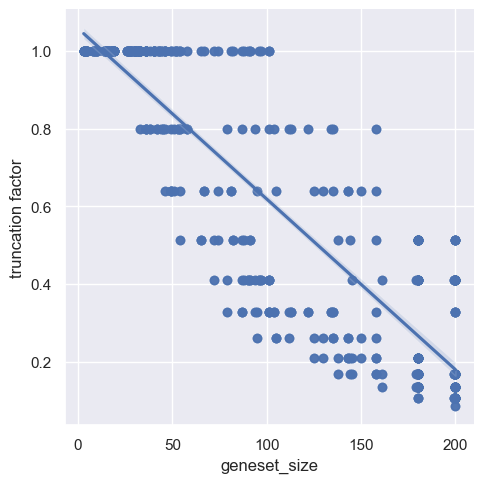

In [69]:

sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
sns.lmplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=df.query("method=='ontological_synopsis'"))
plt.show()

/Users/marcin/.pyenv/versions/3.9.8/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/marcin/.pyenv/versions/3.9.8/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/marcin/.pyenv/versions/3.9.8/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/marcin/.pyenv/versions/3.9.8/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

<Axes: xlabel='geneset_size', ylabel='truncation factor'>

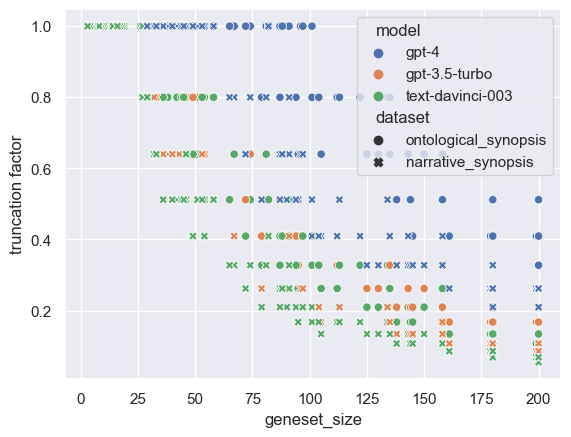

In [70]:
dftups = [(method, df.query(f"method=='{method}'")) for method in ["ontological_synopsis", "narrative_synopsis"]]
for m, mdf in dftups:
    mdf.assign(dataset=m)
concatenated = pd.concat([mdf.assign(dataset=m) for m, mdf in dftups])
sns.scatterplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=concatenated, style='dataset', hue='model')

In [71]:
df.query(f"{GENESET_SIZE} < 50")[[SOURCE_GENESET]].drop_duplicates()

,source geneset
0,glycolysis-gocam
184,EDS
414,peroxisome
506,HALLMARK_ANGIOGENESIS
552,go-postsynapse-calcium-transmembrane
...,...
2898,HALLMARK_PANCREAS_BETA_CELLS
2944,go-reg-autophagy-pkra
2990,HALLMARK_APICAL_SURFACE
3036,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY


In [72]:
df_small = df.query(f"{GENESET_SIZE} < 50")
means = df_small[[MODEL, METHOD] + eval_summary_cols].groupby(['model', 'method']).mean(numeric_only=True)
means

has top term  in top 5  in top 10  \
model            method                                                    
N/A              closure                       1.00      0.00       0.00   
                 random                        0.00      0.00       0.00   
                 rank_based                    0.02      0.00       0.00   
                 standard                      1.00      1.00       1.00   
                 standard_no_ontology          0.61      0.57       0.57   
...                                             ...       ...        ...   
gpt-4            no_synopsis                   0.15      0.15       0.15   
                 ontological_synopsis          0.32      0.30       0.32   
text-davinci-003 narrative_synopsis            0.10      0.10       0.10   
                 no_synopsis                   0.10      0.10       0.10   
                 ontological_synopsis          0.17      0.12       0.15   

                                       size overlap  similarity  num terms  \
model            method                                                      
N/A              closure                     129.11    7.86e-02    2363.85   
                 random                        1.28    6.60e-03      25.74   
                 rank_based                    2.96    1.92e-02      26.72   
                 standard                    129.11    9.83e-01     132.04   
                 standard_no_ontology         28.76    2.18e-01      38.46   
...                                             ...         ...        ...   
gpt-4            no_synopsis                   1.98    2.09e-02       5.95   
                 ontological_synopsis          2.86    3.40e-02       7.45   
text-davinci-003 narrative_synopsis            1.28    1.02e-02      11.63   
                 no_synopsis                   0.91    9.32e-03       7.50   
                 ontological_synopsis          2.08    1.85e-02      11.95   

                                       num GO terms  nr size overlap  \
model            method                                                
N/A              closure                    2321.15             4.67   
                 random                       25.74             0.24   
                 rank_based                   26.72             0.35   
                 standard                    129.11            16.85   
                 standard_no_ontology         38.46             5.78   
...                                             ...              ...   
gpt-4            no_synopsis                   3.32             0.65   
                 ontological_synopsis          5.54             0.88   
text-davinci-003 narrative_synopsis            3.65             0.39   
                 no_synopsis                   2.70             0.25   
                 ontological_synopsis          7.08             0.52   

                                       nr similarity  mean p value  \
model            method                                              
N/A              closure                    2.19e-02      9.16e-01   
                 random                     6.17e-03      9.59e-01   
                 rank_based                 1.07e-02      9.05e-01   
                 standard                   9.80e-01      8.31e-03   
                 standard_no_ontology       1.87e-01      2.94e-01   
...                                              ...           ...   
gpt-4            no_synopsis                4.07e-02      4.01e-01   
                 ontological_synopsis       5.14e-02      4.79e-01   
text-davinci-003 narrative_synopsis         1.79e-02      6.81e-01   
                 no_synopsis                1.69e-02      6.22e-01   
                 ontological_synopsis       2.71e-02      6.81e-01   

                                       min p value  max p value  \
model            method                                           
N/A              closure                  2.89e-06   

In [100]:
def color_lightness(rgb, lightness_scale):
    h, l, s = colorsys.rgb_to_hls(*rgb)
    return colorsys.hls_to_rgb(h, min(1, l * lightness_scale), s = s)

In [97]:

agg_df_plot = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_plot = agg_df_plot.query(f"method != '{x}'")    
    
agg_df_small_plot = df_small.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_small_plot = agg_df_small_plot.query(f"method != '{x}'")
    
agg_df_plot_std = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).std(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_plot_std = agg_df_plot_std.query(f"method != '{x}'")    
    
agg_df_small_plot_std = df_small.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).std(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_small_plot_std = agg_df_small_plot_std.query(f"method != '{x}'")


print(agg_df_small_plot.shape)
print("cols")
print(agg_df_small_plot.columns)

print("index")
print(agg_df_small_plot.index)


(9, 5)
cols
Index(['proportion significant', 'has top term', 'num GO terms',
       'num unannotated', 'num unparsed'],
      dtype='object')
index
MultiIndex([(   'gpt-3.5-turbo',   'narrative synopsis'),
            (   'gpt-3.5-turbo',          'no synopsis'),
            (   'gpt-3.5-turbo', 'ontological synopsis'),
            (           'gpt-4',   'narrative synopsis'),
            (           'gpt-4',          'no synopsis'),
            (           'gpt-4', 'ontological synopsis'),
            ('text-davinci-003',   'narrative synopsis'),
            ('text-davinci-003',          'no synopsis'),
            ('text-davinci-003', 'ontological synopsis')],
           names=['model', 'method'])


method
['model', 'method', 'proportion significant', 'has top term', 'num GO terms', 'num unannotated', 'num unparsed']
model             method              
gpt-3.5-turbo     narrative synopsis      24.75
                  no synopsis             25.33
                  ontological synopsis    35.00
gpt-4             narrative synopsis      31.33
                  no synopsis             41.97
                  ontological synopsis    40.90
text-davinci-003  narrative synopsis      12.80
                  no synopsis             12.51
                  ontological synopsis    20.48
dtype: float64
['red', 'red', 'red', 'purple', 'purple', 'purple', 'orange', 'orange', 'orange']
[(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 0.0039215686274509665, 0.9999999999999998), (1.0, 0.0039215686274509665, 0.9999999999999998), (1.0, 0.0039215686274509665, 0.9999999999999998), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]
{'o', 's', '^'}
['o', '^', 's', 'o', '^', 's', 'o', '^', 's

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_60847/1909417184.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_60847/1909417184.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_60847/1909417184.py:101: FutureWarning: Series.__getitem__ treating keys as position

<Figure size 600x600 with 0 Axes>

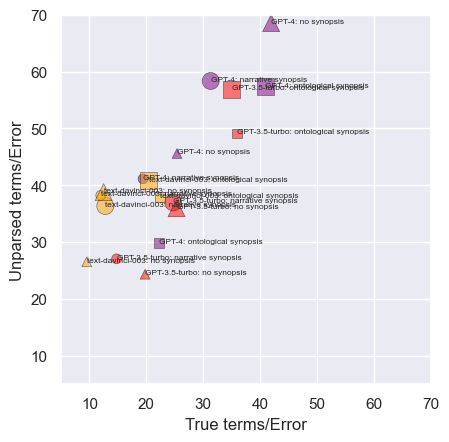

In [101]:

qcols = [MODEL, METHOD] + CORE_METRICS

print(METHOD)
#agg_df_orig = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
#agg_df = pd.DataFrame( columns=agg_df_orig.columns)#NULL#pd.DataFrame() 
#print(EXCLUDE)
#agg_df = agg_df_orig.query(f"method in @METHOD")

print(qcols)

newindex = agg_df_plot.index
#len = agg_df.index.to_flat_index().size()
#print(len)
#for i in range(1,len):
#    newindex[i] = agg_df.index[i]

#print(agg_df.loc[:, 'model'])

#print(agg_df['num GO terms'])

#rework for significant GO terms
xs = agg_df_plot['num GO terms']/agg_df_plot['num unannotated']
ys = agg_df_plot['num unparsed']/agg_df_plot['num unannotated']

xs_small = agg_df_small_plot['num GO terms']/agg_df_small_plot['num unannotated']
ys_small = agg_df_small_plot['num unparsed']/agg_df_small_plot['num unannotated']

#print(agg_df.index)

print(xs)
yells = ["yellow"]*5
reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3

colorr = mpl.colors.ColorConverter.to_rgb("red")
rgbr = [color_lightness(colorr, scale) for scale in [2]]
colorp = mpl.colors.ColorConverter.to_rgb("purple")
rgbp = [color_lightness(colorp, scale) for scale in [2]]
coloro = mpl.colors.ColorConverter.to_rgb("orange")
rgbo = [color_lightness(coloro, scale) for scale in [2]]

redss = rgbr *3
purpss = rgbp *3
oranss = rgbo *3


#colors = [*yells, *reds, *purps, *orans]
colors = [*reds, *purps, *orans]
print(colors)

colors_small = [*redss, *purpss, *oranss]
print(colors_small)

circles= ['o','^','s']*3
#triangles= ['^']*3
#squares= ['s']*3

markers = [*circles]#, *triangles, *squares]

SMALL_SIZE = 6
plt.rc('font', size=SMALL_SIZE)   
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()

#ax.scatter(xs,ys, c=colors, s=50, marker=marker)
#ax.scatter(xs_small,xs_small, c=colors, s=25, marker=marker)

unique_markers = set(markers)
print(unique_markers)
print(markers)

for um in unique_markers:
    #print(um)
    #print(markers.index(um))    
    #print([index for index, elem in enumerate(markers) if elem == um])
    mask = [index for index, elem in enumerate(markers) if elem == um]# markers == um
    maskar = np.array(mask)
    print(mask)
    print(type(mask))
    print(maskar)
    print(type(maskar))
    minv = mask[0]
    maxv = mask[2]
    print(str(minv)+"\t"+str(maxv))
    nowcol = [colors[mask[0]], colors[mask[1]], colors[mask[2]]]
    print(nowcol)
    
    ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
    ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
    
#, label=agg_df.index
agg_df_plot_labels = agg_df_plot.index.values
for i in range(0, len(xs)):
    agg_df_plot_labels[i] = (agg_df_plot_labels[i][0] + ": " + agg_df_plot_labels[i][1]).replace("(","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(")","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(" - "," : ")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace("gpt","GPT")        
                
for i in range(0,len(xs)):
    ax.annotate(agg_df_plot_labels[i], (xs[i], ys[i]))
    ax.annotate(agg_df_plot_labels[i], (xs_small[i], ys_small[i]))  
ax.set_xlabel("True terms/Error")
ax.set_ylabel("Unparsed terms/Error")

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

plt.xlim(5,70)
plt.ylim(5,70)
plt.gca().set_aspect("equal")

plt.savefig("true_vs_unparsed_vs_error.pdf", format="pdf", bbox_inches="tight")

plt.show()

method
['model', 'method', 'proportion significant', 'has top term', 'num GO terms', 'num unannotated', 'num unparsed']
(9, 5)
cols
Index(['proportion significant', 'has top term', 'num GO terms',
       'num unannotated', 'num unparsed'],
      dtype='object')
index
MultiIndex([(   'gpt-3.5-turbo',   'narrative synopsis'),
            (   'gpt-3.5-turbo',          'no synopsis'),
            (   'gpt-3.5-turbo', 'ontological synopsis'),
            (           'gpt-4',   'narrative synopsis'),
            (           'gpt-4',          'no synopsis'),
            (           'gpt-4', 'ontological synopsis'),
            ('text-davinci-003',   'narrative synopsis'),
            ('text-davinci-003',          'no synopsis'),
            ('text-davinci-003', 'ontological synopsis')],
           names=['model', 'method'])
model             method              
gpt-3.5-turbo     narrative synopsis      0.95
                  no synopsis             1.04
                  ontological synopsis

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_60847/3365344334.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_60847/3365344334.py:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_60847/3365344334.py:116: FutureWarning: Series.__getitem__ treating keys as positi

<Figure size 600x600 with 0 Axes>

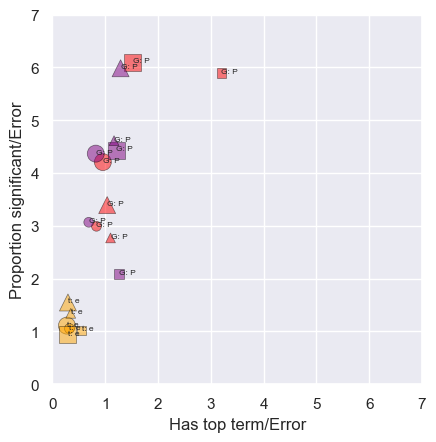

In [102]:

qcols = [MODEL, METHOD] + CORE_METRICS

print(METHOD)
#agg_df_orig = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
#agg_df = pd.DataFrame( columns=agg_df_orig.columns)#NULL#pd.DataFrame() 
#print(EXCLUDE)
#agg_df = agg_df_orig.query(f"method in @METHOD")

print(qcols)

newindex = agg_df_plot.index
#len = agg_df.index.to_flat_index().size()
#print(len)
#for i in range(1,len):
#    newindex[i] = agg_df.index[i]

#print(agg_df.loc[:, 'model'])

#print(agg_df['num GO terms'])

#rework for significant GO terms
xs = agg_df_plot['has top term']/agg_df_plot['num unannotated']
ys = agg_df_plot['proportion significant']/agg_df_plot['num unannotated']

xs_small = agg_df_small_plot['has top term']/agg_df_small_plot['num unannotated']
ys_small = agg_df_small_plot['proportion significant']/agg_df_small_plot['num unannotated']

#print(agg_df.index)

print(xs)
print(ys)
print(np.max(xs))
print(np.max(ys))
print(np.max(xs_small))
print(np.max(ys_small))


yells = ["yellow"]*5
reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3

colorr = mpl.colors.ColorConverter.to_rgb("red")
rgbr = [color_lightness(colorr, scale) for scale in [2]]
colorp = mpl.colors.ColorConverter.to_rgb("purple")
rgbp = [color_lightness(colorp, scale) for scale in [2]]
coloro = mpl.colors.ColorConverter.to_rgb("orange")
rgbo = [color_lightness(coloro, scale) for scale in [2]]

redss = rgbr *3
purpss = rgbp *3
oranss = rgbo *3


#colors = [*yells, *reds, *purps, *orans]
colors = [*reds, *purps, *orans]
print(colors)

colors_small = [*redss, *purpss, *oranss]
print(colors_small)

circles= ['o','^','s']*3
#triangles= ['^']*3
#squares= ['s']*3

markers = [*circles]#, *triangles, *squares]

SMALL_SIZE = 6
plt.rc('font', size=SMALL_SIZE)   
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()

#ax.scatter(xs,ys, c=colors, s=50, marker=marker)
#ax.scatter(xs_small,xs_small, c=colors, s=25, marker=marker)

unique_markers = set(markers)
print(unique_markers)
print(markers)

for um in unique_markers:
    #print(um)
    #print(markers.index(um))    
    #print([index for index, elem in enumerate(markers) if elem == um])
    mask = [index for index, elem in enumerate(markers) if elem == um]# markers == um
    maskar = np.array(mask)
    print(mask)
    print(type(mask))
    print(maskar)
    print(type(maskar))
    minv = mask[0]
    maxv = mask[2]
    print(str(minv)+"\t"+str(maxv))
    nowcol = [colors[mask[0]], colors[mask[1]], colors[mask[2]]]
    print(nowcol)
    
    ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
    ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
    
#, label=agg_df.index
agg_df_plot_labels = agg_df_plot.index.values
for i in range(0, len(xs)):
    agg_df_plot_labels[i] = (agg_df_plot_labels[i][0] + ": " + agg_df_plot_labels[i][1]).replace("(","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(")","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(" - "," : ")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace("gpt","GPT")        
                
for i in range(0,len(xs)):
    ax.annotate(agg_df_plot_labels[i], (xs[i], ys[i]))
    ax.annotate(agg_df_plot_labels[i], (xs_small[i], ys_small[i]))  
ax.set_xlabel("Has top term/Error")
ax.set_ylabel("Proportion significant/Error")

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

plt.xlim(0,7)
plt.ylim(0,7)
plt.gca().set_aspect("equal")

plt.savefig("top_vs_proportion_vs_error.pdf", format="pdf", bbox_inches="tight")

plt.show()

method
['model', 'method', 'proportion significant', 'has top term', 'num GO terms', 'num unannotated', 'num unparsed']
model             method              
gpt-3.5-turbo     narrative synopsis      0.15
                  no synopsis             0.20
                  ontological synopsis    0.15
gpt-4             narrative synopsis      0.11
                  no synopsis             0.14
                  ontological synopsis    0.17
text-davinci-003  narrative synopsis      0.09
                  no synopsis             0.08
                  ontological synopsis    0.10
Name: has top term, dtype: float64
model             method              
gpt-3.5-turbo     narrative synopsis      0.65
                  no synopsis             0.66
                  ontological synopsis    0.62
gpt-4             narrative synopsis      0.60
                  no synopsis             0.65
                  ontological synopsis    0.61
text-davinci-003  narrative synopsis      0.37
               

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_60847/1366996683.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_60847/1366996683.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_60847/1366996683.py:104: FutureWarning: Series.__getitem__ treating keys as positi

<Figure size 600x600 with 0 Axes>

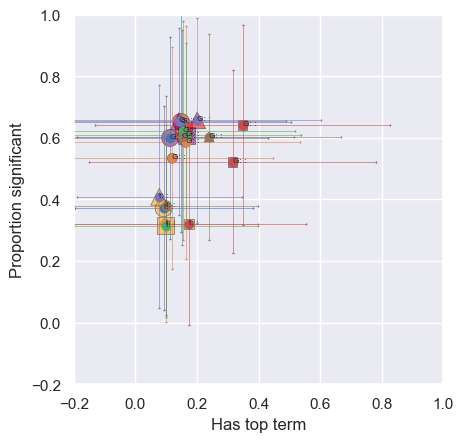

In [122]:

qcols = [MODEL, METHOD] + CORE_METRICS

print(METHOD)
#agg_df_orig = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
#agg_df = pd.DataFrame( columns=agg_df_orig.columns)#NULL#pd.DataFrame() 
#print(EXCLUDE)
#agg_df = agg_df_orig.query(f"method in @METHOD")

print(qcols)

newindex = agg_df_plot.index
#len = agg_df.index.to_flat_index().size()
#print(len)
#for i in range(1,len):
#    newindex[i] = agg_df.index[i]

#print(agg_df.loc[:, 'model'])

#print(agg_df['num GO terms'])

#rework for significant GO terms
xs = agg_df_plot['has top term']
ys = agg_df_plot['proportion significant']
xs_er = agg_df_plot_std['has top term']
ys_er = agg_df_plot_std['proportion significant']

xs_small = agg_df_small_plot['has top term']
ys_small = agg_df_small_plot['proportion significant']
xs_small_er = agg_df_small_plot_std['has top term']
ys_small_er = agg_df_small_plot_std['proportion significant']


#print(agg_df.index)

print(xs)
print(ys)
print(np.max(xs))
print(np.max(ys))
print(np.max(xs_small))
print(np.max(ys_small))


yells = ["yellow"]*5
reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3

colorr = mpl.colors.ColorConverter.to_rgb("red")
rgbr = [color_lightness(colorr, scale) for scale in [2]]
colorp = mpl.colors.ColorConverter.to_rgb("purple")
rgbp = [color_lightness(colorp, scale) for scale in [2]]
coloro = mpl.colors.ColorConverter.to_rgb("orange")
rgbo = [color_lightness(coloro, scale) for scale in [2]]

redss = rgbr *3
purpss = rgbp *3
oranss = rgbo *3


#colors = [*yells, *reds, *purps, *orans]
colors = [*reds, *purps, *orans]
print(colors)

colors_small = [*redss, *purpss, *oranss]
print(colors_small)

circles= ['o','^','s']*3
#triangles= ['^']*3
#squares= ['s']*3

markers = [*circles]#, *triangles, *squares]

SMALL_SIZE = 6
plt.rc('font', size=SMALL_SIZE)   
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()

#ax.scatter(xs,ys, c=colors, s=50, marker=marker)
#ax.scatter(xs_small,xs_small, c=colors, s=25, marker=marker)

unique_markers = set(markers)
print(unique_markers)
print(markers)

for um in unique_markers:
    #print(um)
    #print(markers.index(um))    
    #print([index for index, elem in enumerate(markers) if elem == um])
    mask = [index for index, elem in enumerate(markers) if elem == um]# markers == um
    maskar = np.array(mask)
    print(mask)
    print(type(mask))
    print(maskar)
    print(type(maskar))
    minv = mask[0]
    maxv = mask[2]
    print(str(minv)+"\t"+str(maxv))
    nowcol = [colors[mask[0]], colors[mask[1]], colors[mask[2]]]
    print(nowcol)
    
    ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
    ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)

    ax.errorbar(xs[mask], ys[mask], xerr= xs_er[mask], yerr=ys_er[mask], fmt="o", elinewidth=0.4, capsize=0.4)# ecolor=nowcol,
    ax.errorbar(xs_small[mask], ys_small[mask], xerr= xs_small_er[mask], yerr=ys_small_er[mask], fmt="o", elinewidth=0.4, capsize=0.4)
    
#, label=agg_df.index
agg_df_plot_labels = agg_df_plot.index.values
for i in range(0, len(xs)):
    agg_df_plot_labels[i] = (agg_df_plot_labels[i][0] + ": " + agg_df_plot_labels[i][1]).replace("(","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(")","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(" - "," : ")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace("gpt","GPT")        
                
for i in range(0,len(xs)):
    ax.annotate(agg_df_plot_labels[i], (xs[i], ys[i]))
    ax.annotate(agg_df_plot_labels[i], (xs_small[i], ys_small[i]))  
ax.set_xlabel("Has top term")
ax.set_ylabel("Proportion significant")

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

plt.xlim(-0.2,1)
plt.ylim(-0.2,1)
plt.gca().set_aspect("equal")

plt.savefig("top_vs_proportion_std.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [74]:
means.query("method != 'standard'").style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

## TABLE: evaluation for gene sets < 75

In [75]:
agg_table(df_small, CORE_METRICS, EXCLUDE)

,model,method,proportion significant,has top term,num GO terms,num unannotated,num unparsed
0,gpt-3.5-turbo,narrative synopsis,0.585,0.163,2.891,0.196,5.293
1,gpt-3.5-turbo,no synopsis,0.602,0.239,4.304,0.217,5.293
2,gpt-3.5-turbo,ontological synopsis,0.641,0.348,3.913,0.109,5.337
3,gpt-4,narrative synopsis,0.533,0.120,3.380,0.174,7.152
4,gpt-4,no synopsis,0.602,0.152,3.315,0.130,5.946
5,gpt-4,ontological synopsis,0.522,0.315,5.543,0.250,7.446
6,text-davinci-003,narrative synopsis,0.320,0.098,3.652,0.304,11.630
7,text-davinci-003,no synopsis,0.379,0.098,2.696,0.283,7.500
8,text-davinci-003,ontological synopsis,0.321,0.174,7.076,0.315,11.946


## Looking at individual gene sets

In [76]:

def terms_summary(df, variant="v1", max_rows=9999):
    term_dict = {}
    n = 0
    for _, row in df.iterrows():
        if row[PROMPT_VARIANT] and row[PROMPT_VARIANT] != variant:
            continue
        n += 1
        if n > max_rows:
            break
        model = row['model'] 
        if "turbo" in model:
            model = "turbo"
        elif "davinci" in model:
            model = "dav"
        else:
            model = ""
        method = str(row['method']).replace('_', ' ')
        if method in ["closure", "rank_based", "random"]:
            continue
        mm = f"{model} {method}"
        if method == "standard":
            nr_term_ids = list(filter_redundant(row[TERM_IDS]))
        else:
            nr_term_ids = None
        for ix, t_id in enumerate(row[TERM_IDS]):
            if t_id not in term_dict:
                t = {"id": t_id, "label": go.label(t_id), "redundant": False}
                term_dict[t_id] = t
            else:
                t = term_dict[t_id]
            t[mm] = ix
            if nr_term_ids and t_id not in nr_term_ids:
                t["redundant"] = True
    objs = list(term_dict.values())
    return pd.DataFrame(objs)

In [77]:
import oaklib.datamodels.obograph as og
from oaklib.utilities.obograph_utils import graph_to_image, default_stylemap_path
!mkdir -p output

MMAP = {"standard": None, 
        "gpt-3.5-turbo.no_synopsis": "NS",
        "gpt-3.5-turbo.ontological_synopsis": "ONT",
        "gpt-3.5-turbo.narrative_synopsis": "NAR",
       }

def viz(geneset, include_std=True, mmap = MMAP, variant="v1"):
    methods = mmap.keys()
    [gsobj] = [c for c in comps if c.name == geneset]
    std = gsobj.payloads["standard"]
    t2p = {e.class_id : e.p_value_adjusted for e in std.enrichment_results}
    terms = set()
    terms.add("GO:0008150")
    terms.add("GO:0003674")
    terms.add("GO:0005575")
    m2t = defaultdict(list)
    t2m = defaultdict(set)
    seeds = []
    for m in methods:
        if m == "standard":
            mv = m
        else:
            mv = f"{m}.{variant}"
        p = gsobj.payloads[mv]
        if include_std or m != "standard":
            terms.update(p.term_ids)
        for t in p.term_ids:
            if t.startswith("MONDO:"):
                continue
            m2t[m].append(t)
            t2m[t].add(m)
            if m == "standard":
                seeds.append(t)
    # rels = go.gap_fill_relationships(list(terms), predicates=[IS_A, PART_OF, "RO:0002211", "RO:0002212", RO:0002213"])
    rels = go.gap_fill_relationships(list(terms), predicates=[IS_A, PART_OF])
    g = go.relationships_to_graph(rels)
    for n in g.nodes:
        if not n.lbl:
            n.lbl = go.label(n.id)
        if not n.lbl:
            n.lbl = n.id
        if n.id in t2p:
            n.lbl += f" {t2p[n.id]:.2e}"
        #for m in t2m[n.id]:
        #    n.lbl += f" [<b>{m}</b>]"
    for m in m2t.keys():
        if m == "standard":
            continue
        for t in m2t[m]:
            n = og.Node(id=f"{mmap[m]}:{t}", lbl=mmap[m])
            g.nodes.append(n)
            g.edges.append(og.Edge(n.id, "has", t))
    outfile = f"output/{geneset.replace(' ', '_')}-{include_std}-{variant}.png"
    graph_to_image(g, seeds=seeds, imgfile=outfile, stylemap="conf/enr-style.json")
    graph_to_image(g, seeds=seeds, imgfile=outfile, stylemap="conf/enr-style.json")
    #return g
    
viz('peroxisome-0')
viz('peroxisome-0', variant="v2")

ERROR:root:No og2dot


You need to install a node package to be able to visualize results

npm install -g obographviz
Then set your path to include og2dot


Exception: Cannot find og2dot on path. Install from https://github.com/INCATools/obographviz

In [ ]:
def geneset_summary(df, geneset):
    sdf = terms_summary(df.query(f"{GENESET} == '{geneset}'").sort_values("similarity", ascending=False))
    [gsobj] = [c for c in comps if c.name == geneset]
    std = gsobj.payloads["standard"]
    t2p = {e.class_id : e.p_value_adjusted for e in std.enrichment_results}
    sdf["p_label"] = sdf.apply(lambda row: str(row.label) + " " + str(t2p.get(row.id, "")), axis=1)
    return sdf

geneset_summary(df, 'peroxisome-0')

### Peroxisome

In [ ]:
peroxisome = df.query(f"{GENESET} == 'peroxisome-0'").sort_values("similarity", ascending=False)
peroxisome[[MODEL, METHOD] + eval_summary_cols]

In [ ]:
# terms_summary(peroxisome).style.highlight_min(axis=1, props='font-weight:bold', numeric_only=True)
terms_summary(peroxisome)

In [ ]:
terms_summary(peroxisome, "v2")

## Sensory Ataxia

In [ ]:
ataxia = df.query(f"{GENESET} == 'sensory ataxia-0'").sort_values("similarity", ascending=False)
ataxia[[MODEL, METHOD] + eval_summary_cols]                                                  

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


In [ ]:
ataxia[[MODEL, METHOD, PROMPT_VARIANT, GO_TERM_IDS, NOVEL_LABELS]]

In [ ]:
viz('sensory ataxia-0')

![img](output/sensory_ataxia-0-True-v1.png)

In [ ]:
viz('sensory ataxia-0', variant="v2")

![img](output/sensory_ataxia-0-True-v2.png)

In [ ]:
terms_summary(ataxia)

In [ ]:
def retrieve_payload(geneset, method):
    for comp in comps:
        if comp.name == geneset:
            return comp.payloads[method]

In [ ]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.ontological_synopsis.v1").response_text)

In [ ]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.narrative_synopsis.v1").response_text)

In [ ]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.no_synopsis.v1").response_text)

## T cell proliferation

In [ ]:
tcp = df.query(f"{GENESET} == 'T cell proliferation-0'").sort_values("similarity", ascending=False)
tcp[[MODEL, METHOD] + eval_summary_cols]

In [ ]:
viz('T cell proliferation-0')

![img](output/T_cell_proliferation-0-True-v1.png)

In [ ]:
terms_summary(tcp)

## Endocytosis

In [ ]:
endocytosis = df.query(f"{GENESET} == 'endocytosis-0'").sort_values("similarity", ascending=False)
terms_summary(endocytosis)

In [ ]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.narrative_synopsis.v1").prompt)

In [ ]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.narrative_synopsis.v1").response_text)

In [ ]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.ontological_synopsis.v1").prompt)

## Hydrolysis

In [ ]:
hydrolysis = df.query(f"{GENESET} == 'hydrolase activity, hydrolyzing O-glycosyl compounds-0'").sort_values("similarity", ascending=False)
terms_summary(hydrolysis)

In [ ]:
viz('hydrolase activity, hydrolyzing O-glycosyl compounds-0')

![img](output/hydrolase_activity,_hydrolyzing_O-glycosyl_compounds-0-True-v1.png)

## Variability

In [ ]:
pv_pivot = df.pivot_table(index=[MODEL, METHOD, GENESET], columns=PROMPT_VARIANT, values=PROPOTION_SIGNIFICANT)
# Calculate differences between run "1" and run "2"
pv_pivot['diff'] = pv_pivot["v1"] - pv_pivot["v2"]
pv_pivot

In [ ]:

# Now you can perform statistics on the 'diff' column
df_diff_stats = pv_pivot['diff'].agg(['mean', 'std', 'var', 'min', 'max'])
df_diff_stats['range'] = df_diff_stats['max'] - df_diff_stats['min']
df_diff_stats

In [ ]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

# pivot your dataframe as before
df_pivot = df.pivot_table(index=[MODEL, METHOD, GENESET], columns=PROMPT_VARIANT, values=TERM_IDS, aggfunc=list)
df_pivot

In [ ]:

# calculate Jaccard index for each group
df_pivot['jaccard_index'] = df_pivot.apply(lambda row: jaccard_similarity(row["v1"][0], row["v2"][0]), axis=1)

# reset index to get it back in the form of a DataFrame
result = df_pivot.reset_index()
result

In [ ]:
result['jaccard_index'].describe()

In [ ]:
result.groupby([MODEL])['jaccard_index'].describe()

In [ ]:
result.groupby([MODEL, METHOD])['jaccard_index'].describe()[['count', 'mean', 'std', 'min', 'max']].style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [ ]:
summaries = [s for s in list(df[SUMMARY]) if s]
len(summaries)
import random
def random_summary():
    return summaries[int(random.random() * len(summaries))]

random_summary()

In [ ]:
from ontogpt.clients import OpenAIClient

simclient = OpenAIClient(model="text-embedding-ada-002")

def text_similarity(text1, text2):
    return simclient.similarity(text1, text2)

text_similarity("nucleus of cell", "nuclear membrane")

In [ ]:
text_similarity(random_summary(), random_summary())

In [ ]:
rs = random_summary()
text_similarity(rs, rs)

In [ ]:
df_pivot = df.pivot_table(index=[MODEL, METHOD, GENESET], columns=PROMPT_VARIANT, values=SUMMARY, aggfunc=list)
df_pivot

df_pivot['sim'] = df_pivot.apply(lambda row: text_similarity(row["v1"][0], row["v2"][0]), axis=1)
df_pivot['length_diff'] = df_pivot.apply(lambda row: abs(len(row["v1"][0])-len(row["v2"][0])), axis=1)


# reset index to get it back in the form of a DataFrame
result = df_pivot.reset_index()
result

In [ ]:
rnd = result.query("model=='text-davinci-003' and method=='no_synopsis'")
rnd[MODEL]=""
rnd[METHOD]="RANDOM"
rnd["sim"] = rnd.apply(lambda row: text_similarity(random_summary(), random_summary()), axis=1)
rnd

In [ ]:
sim_summary = pd.concat([result, rnd]).groupby([MODEL, METHOD])['sim'].describe()[['count', 'mean', 'std', 'min', 'max']]
sim_summary.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [ ]:
stats_df = result.groupby(METHOD).agg({'sim': [np.mean, np.std]}).reset_index()
stats_df.columns = ['category', 'mean', 'stddev']

# Set the plot style
sns.set(style="whitegrid")

# Create the bar plot with error bars
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='category', y='mean', data=stats_df, yerr=stats_df['stddev'], capsize=.1)

# Add labels and title
plt.xlabel("Category")
plt.ylabel("Mean Score")
plt.title("Mean Score with Standard Deviation for Each Category")

# Show the plot
plt.show()


In [ ]:
diff_summary = result.groupby([MODEL, METHOD])['length_diff'].describe()[['count', 'mean', 'std', 'min', 'max']]
diff_summary.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

## Unparsed

In [ ]:
def unparsed(df, model):
    novel_term_map = defaultdict(dict)
    for _, row in df.iterrows():
        gs = row[GENESET]
        #if not gs.endswith("-0"):
        #    continue
        gs = gs.replace("-0", "")
        for lbl in row[NOVEL_LABELS]:
            if row[MODEL] != model:
                continue
            m = row[METHOD]
            novel_term_map[lbl]["NAME"] = lbl
            if gs not in novel_term_map[lbl]:
                novel_term_map[lbl][m] = []
            novel_term_map[lbl][m].append(gs)
    novel_df = pd.DataFrame(novel_term_map.values())
    return novel_df

## Potential Hallucinations

Summarize all GO terms that are in all summaries that are not in the closure of annotated terms for any of the genes in the gene set

In [ ]:
def hallucinatons(df, model):
    novel_term_map = defaultdict(dict)
    for _, row in df.iterrows():
        gs = row[GENESET]
        #if not gs.endswith("-0"):
        #    continue
        gs = gs.replace("-0", "")
        for lbl in row[NOVEL_LABELS]:
            if row[MODEL] != model:
                continue
            m = row[METHOD]
            novel_term_map[lbl]["NAME"] = lbl
            if gs not in novel_term_map[lbl]:
                novel_term_map[lbl][m] = []
            novel_term_map[lbl][m].append(gs)
    novel_df = pd.DataFrame(novel_term_map.values())
    return novel_df

In [ ]:
novel_df_turbo = hallucinatons(df, TURBO).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
novel_df_turbo

In [ ]:
hallucinatons(df, DAVINCI)

In [ ]:
hallucinatons(df, GPT4)

In [ ]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4")
enc.encode("negative regulation")

def tok_similarity(t1, t2):
    if t1 is None and t2 is None:
        return 1
    if t1 is None or t2 is None:
        return 0

    toks1 = set(enc.encode(t1))
    toks2 = set(enc.encode(t2))
    return len(toks1.intersection(toks2)) / len(toks1.union(toks2))


In [ ]:
closure_by_gene_set = {}
for comp in comps:
    closure = comp.payloads["closure"].term_strings
    closure_by_gene_set[comp.name] = closure

def hallucinatons_with_best_match(df, model):
    novel_term_map = defaultdict(dict)
    for _, row in df.iterrows():
        gs = row[GENESET]
        # print(gs)
        closure = closure_by_gene_set[gs]
        #if not gs.endswith("-0"):
        #    continue
        gs = gs.replace("-0", "")
        for lbl in row[NOVEL_LABELS]:
            if row[MODEL] != model:
                continue
            m = row[METHOD]
            novel_term_map[lbl]["NAME"] = lbl
            if gs not in novel_term_map[lbl]:
                novel_term_map[lbl][m] = []
            # sims = [(ct, text_similarity(ct, lbl)) for ct in closure]
            sims = [(ct, tok_similarity(ct, lbl)) for ct in closure]
            sims = sorted(sims, key=lambda x: -x[1])
            best = sims[0][0]
            novel_term_map[lbl][m].append((gs, best))
    novel_df = pd.DataFrame(novel_term_map.values())
    return novel_df

novel_df_turbo = hallucinatons_with_best_match(df, TURBO).reset_index(drop=True)
novel_df_turbo

## New Annotations

In [ ]:
endocytosis = df.query(f"{GENESET} == 'endocytosis-0'").sort_values("similarity", ascending=False)
terms_summary(endocytosis)

In [ ]:
viz('endocytosis-0')

![img](output/endocytosis-0-True-v1.png)

### New Annotations

in 2022-03-24, GO `molecular sequesting` only had 6 genes annotated; this increased to 30 in 2023.
If these are past the LLM training date then we would not expect these to influence results. Additionally,


In [ ]:
sequestering = df.query(f"{GENESET} == 'molecular sequestering-0'").sort_values("similarity", ascending=False)
sequestering[eval_summary_cols]                                                           

In [ ]:
terms_summary(sequestering)

In [ ]:
viz('molecular sequestering-0')

![img](output/molecular_sequestering-0-True-v1.png)

## IGRB

This gene set contains genes previously annotated to IGRB, many of which have been since removed

In [ ]:
igrb = df.query(f"{GENESET} == 'ig-receptor-binding-2022-0'").sort_values("similarity", ascending=False)
terms_summary(igrb)

In [ ]:
viz('ig-receptor-binding-2022-0')

![img](output/ig-receptor-binding-2022-0-True-v1.png)

In [ ]:
viz('HALLMARK_GLYCOLYSIS-0')

![img](output/HALLMARK_GLYCOLYSIS-0-True-v1.png)

In [ ]:
viz('HALLMARK_KRAS_SIGNALING_UP-0')

![img](output/HALLMARK_KRAS_SIGNALING_UP-0-True-v1.png)

## Summaries

In [ ]:
objs = []
for c in comps:
    for m, payload in c.payloads.items():
        if payload.summary:
            objs.append({"model": c.model, "geneset": c.name, "method": m, "summary": payload.summary})

In [ ]:
sdf = pd.DataFrame(objs)

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
sdf

In [ ]:
sdf.query("geneset == 'sensory ataxia-0'")